In [19]:
import numpy as np
import matplotlib.pyplot as plt

##############################################
# Generating data points for 3(a) and splitting
##############################################

x = np.linspace(0, 1, 100).reshape(-1, 1)

# Generate noise from N(0, 0.1)
np.random.seed(0)
noise = np.random.normal(0, np.sqrt(0.1), size=x.shape)

# Compute target values t_n = sin(2πx_n) + ε_n
t = np.sin(2 * np.pi * x) + noise
t = t.reshape(-1, 1)

# Split data: even samples for training, odd samples for testing
x_train = x[::2]
t_train = t[::2]
x_test = x[1::2]
t_test = t[1::2]

# print(f"Training set size: {len(x_train)}")
# print(f"Test set size: {len(x_test)}")

In [20]:
#########################################
# Functions to implement kernel regression
#########################################

# Function to calculate the mean squared error
def mean_squared_error(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return np.mean((y_true - y_pred) ** 2)

# Function to find the kernel vector with dimensions 100 x M+1
def get_kernel(x, M, kernelType):
    """
    Generate kernel matrix based on kernel type
    Args:
        x: input data (N x 1)
        M: polynomial order
        kernelType: 'polynomial', 'gaussian', or 'sigmoid'
    Returns:
        Kernel matrix (N x (M+1))
    """

    if kernelType == "polynomial":
        # Polynomial kernel: [1, x, x^2, ..., x^M]
        return np.hstack([x**i for i in range(M + 1)])

    elif kernelType == "gaussian":
        # Gaussian kernel with centers uniformly distributed
        centers = np.linspace(x.min(), x.max(), M + 1).reshape(1, -1)
        sigma = 0.3
        return np.exp(-((x - centers) ** 2) / (2 * sigma**2))

    elif kernelType == "sigmoid":
        # Sigmoid kernel: tanh(a*x + b_i) for i = 0, 1, ..., M
        a = 1.0
        b = 0.0
        return np.hstack([np.tanh(a * x + b + i) for i in range(M + 1)])

    else:
        raise ValueError(f"Unknown kernel type: {kernelType}")


def KernelRegressionFit(X_train, Y_train, kernelType, M, lamda):
    """
    Fit kernel regression model
    Args:
        X_train: training data (N x 1)
        Y_train: training targets (N x 1)
        kernelType: type of kernel
        M: polynomial order
        lamda: regularization coefficient
    Returns:
        w_opt: optimal weights
    """
    # Get design matrix
    phi = get_kernel(X_train, M, kernelType)

    # Regularized least squares solution
    I = np.eye(phi.shape[1])
    w_opt = np.linalg.inv(phi.T @ phi + lamda * I) @ phi.T @ Y_train

    return w_opt


def KernelRegressionPred_Error(w_est, X_train, Y_train, X_test, Y_test, kernelType, M):
    """
    Compute training and testing errors
    Args:
        w_est: estimated weights
        X_train: training data
        Y_train: training targets
        X_test: test data
        Y_test: test targets
        kernelType: type of kernel
        M: polynomial order
    Returns:
        TrainError: training MSE
        TestError: testing MSE
    """
    # Get kernel matrices
    Phi_train = get_kernel(X_train, M, kernelType)
    Phi_test = get_kernel(X_test, M, kernelType)

    # Make predictions
    Y_train_pred = Phi_train @ w_est
    Y_test_pred = Phi_test @ w_est

    # Compute MSE
    TrainError = mean_squared_error(Y_train, Y_train_pred)
    TestError = mean_squared_error(Y_test, Y_test_pred)

    return TrainError, TestError

In [21]:
# not tuning for different values of a or b
def tune_hyperparameters(X_train, Y_train, X_test, Y_test, kernelType, M):
    """
    Tune hyperparameters for a given kernel type and model order M
    """
    lambda_values = np.logspace(-5, 1, 20)
    best_lambda = None
    best_test_error = float("inf")

    for lam in lambda_values:
        try:
            # Fit model
            w_est = KernelRegressionFit(X_train, Y_train, kernelType, M, lam)

            # Evaluate error
            train_err, test_err = KernelRegressionPred_Error(
                w_est, X_train, Y_train, X_test, Y_test, kernelType, M
            )

            if test_err < best_test_error:
                best_test_error = test_err
                best_lambda = lam

        except Exception as e:
            continue
    print(
        f"Best λ for Polynomial Kernel = {best_lambda:.5f} with Test Error = {best_test_error:.4f}"
    )

    return best_lambda, best_test_error


def tune_all_kernels(X_train, Y_train, X_test, Y_test, M_range):
    """
    Tune hyperparameters for all kernel types across all M values
    """
    kernel_types = ["polynomial", "gaussian", "sigmoid"]
    best_params_dict = {}

    print("=== Hyperparameter Tuning ===")
    for M in M_range:
        print(f"\nModel Order M = {M}")
        best_params_dict[M] = {}

        for kernel in kernel_types:
            best_lambda, best_error = tune_hyperparameters(
                X_train, Y_train, X_test, Y_test, kernel, M
            )
            best_params_dict[M][kernel] = best_lambda
            print(
                f"  {kernel.capitalize()}: λ = {best_lambda:.5f}, Test Error = {best_error:.4f}"
            )

    return best_params_dict

In [22]:
# Cell 4: Plotting Functions
def PlotPrediction(X_train, Y_train, X_test, Y_test, M, best_params):
    """
    Plot predictions for all kernel types at a given model order M
    """
    kernel_types = ["polynomial", "gaussian", "sigmoid"]
    x_vis = np.linspace(X_train.min(), X_train.max(), 500).reshape(-1, 1)

    plt.figure(figsize=(15, 4))

    for i, kernel in enumerate(kernel_types):
        # Get best lambda for this kernel
        lamda = best_params[kernel]

        # Fit model
        w_est = KernelRegressionFit(X_train, Y_train, kernel, M, lamda)

        # Get predictions for visualization
        Phi_vis = get_kernel(x_vis, M, kernel)
        y_vis = Phi_vis @ w_est

        # Compute errors
        train_err, test_err = KernelRegressionPred_Error(
            w_est, X_train, Y_train, X_test, Y_test, kernel, M
        )

        # Plot
        plt.subplot(1, 3, i + 1)
        plt.title(
            f"{kernel.capitalize()} Kernel (M={M})\nTrain MSE: {train_err:.4f}, Test MSE: {test_err:.4f}"
        )
        plt.plot(x_vis, y_vis, label="Model prediction", color="red", linewidth=2)
        plt.scatter(X_train, Y_train, label="Train data", color="blue", s=20, alpha=0.7)
        plt.scatter(X_test, Y_test, label="Test data", color="green", marker="x", s=30)
        plt.xlabel("x")
        if i == 0:
            plt.ylabel("t")
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def PlotErrors(X_train, Y_train, X_test, Y_test, M_range, best_params_dict):
    """
    Plot training and testing errors vs model order M for all kernel types
    """
    kernel_types = ["polynomial", "gaussian", "sigmoid"]
    colors = ["red", "green", "blue"]

    # Error containers
    error_dict = {kernel: {"train": [], "test": []} for kernel in kernel_types}

    for kernel in kernel_types:
        for M in M_range:
            # Get best lambda for this kernel and M
            lamda = best_params_dict[M][kernel]

            # Fit the model
            w_est = KernelRegressionFit(X_train, Y_train, kernel, M, lamda)

            # Compute errors
            train_err, test_err = KernelRegressionPred_Error(
                w_est, X_train, Y_train, X_test, Y_test, kernel, M
            )

            # Store errors
            error_dict[kernel]["train"].append(train_err)
            error_dict[kernel]["test"].append(test_err)

    # Plotting
    plt.figure(figsize=(12, 6))

    for i, kernel in enumerate(kernel_types):
        color = colors[i]
        plt.plot(
            M_range,
            error_dict[kernel]["train"],
            color=color,
            linestyle="--",
            label=f"{kernel.capitalize()} Train",
            linewidth=2,
        )
        plt.plot(
            M_range,
            error_dict[kernel]["test"],
            color=color,
            linestyle="-",
            label=f"{kernel.capitalize()} Test",
            linewidth=2,
        )

    plt.xlabel("Model Order (M)")
    plt.ylabel("Mean Squared Error")
    plt.title("Train/Test Error vs Model Order for Each Kernel")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [23]:
# Cell 5: Part 3(a) - Sine Function Analysis
# Define M range for analysis
M_range = list(range(10))

# Tune hyperparameters for sine function data
print("PART 3(a): Sine Function Analysis")
print("=" * 50)
best_params_dict_sine = tune_all_kernels(x_train, t_train, x_test, t_test, M_range)

PART 3(a): Sine Function Analysis
=== Hyperparameter Tuning ===

Model Order M = 0
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.6024
  Polynomial: λ = 0.00001, Test Error = 0.6024
Best λ for Polynomial Kernel = 1.12884 with Test Error = 0.4323
  Gaussian: λ = 1.12884, Test Error = 0.4323
Best λ for Polynomial Kernel = 4.83293 with Test Error = 0.5570
  Sigmoid: λ = 4.83293, Test Error = 0.5570

Model Order M = 1
Best λ for Polynomial Kernel = 0.54556 with Test Error = 0.3397
  Polynomial: λ = 0.54556, Test Error = 0.3397
Best λ for Polynomial Kernel = 2.33572 with Test Error = 0.2871
  Gaussian: λ = 2.33572, Test Error = 0.2871
Best λ for Polynomial Kernel = 0.26367 with Test Error = 0.3227
  Sigmoid: λ = 0.26367, Test Error = 0.3227

Model Order M = 2
Best λ for Polynomial Kernel = 0.00018 with Test Error = 0.3314
  Polynomial: λ = 0.00018, Test Error = 0.3314
Best λ for Polynomial Kernel = 2.33572 with Test Error = 0.2782
  Gaussian: λ = 2.33572, Test Error = 0.2782
Bes


=== Plotting Predictions for Sine Function ===

Plotting for Model Order M = 0


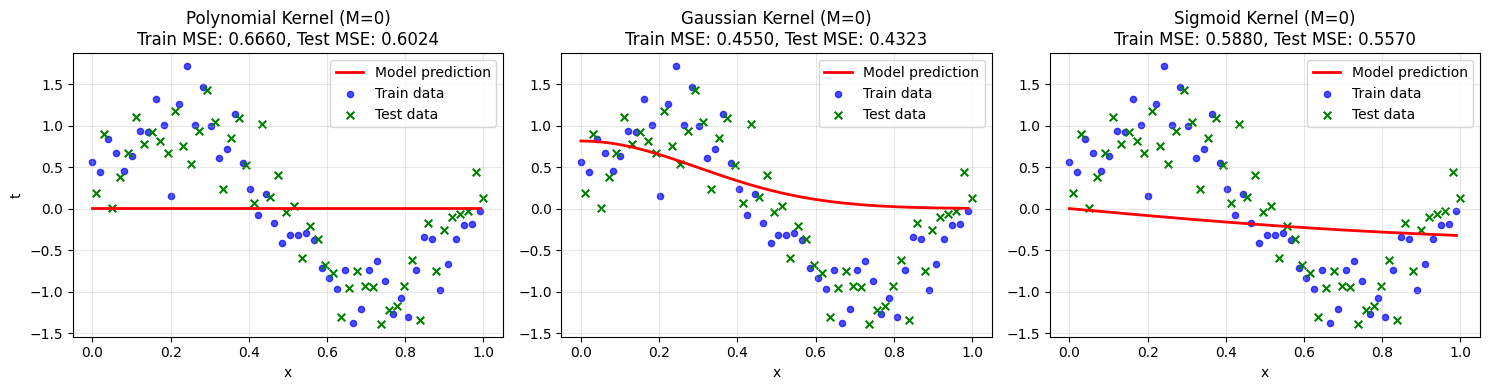


Plotting for Model Order M = 1


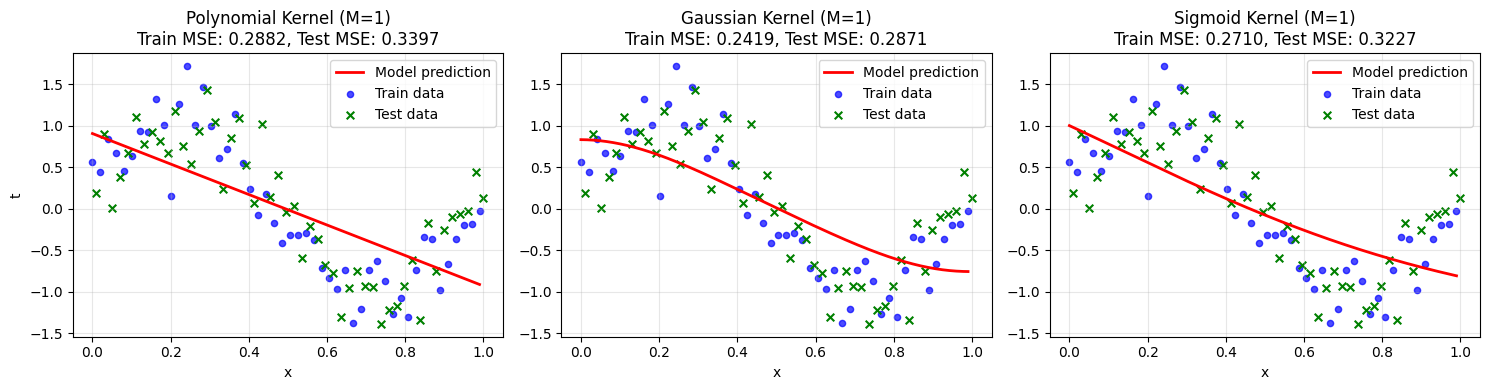


Plotting for Model Order M = 2


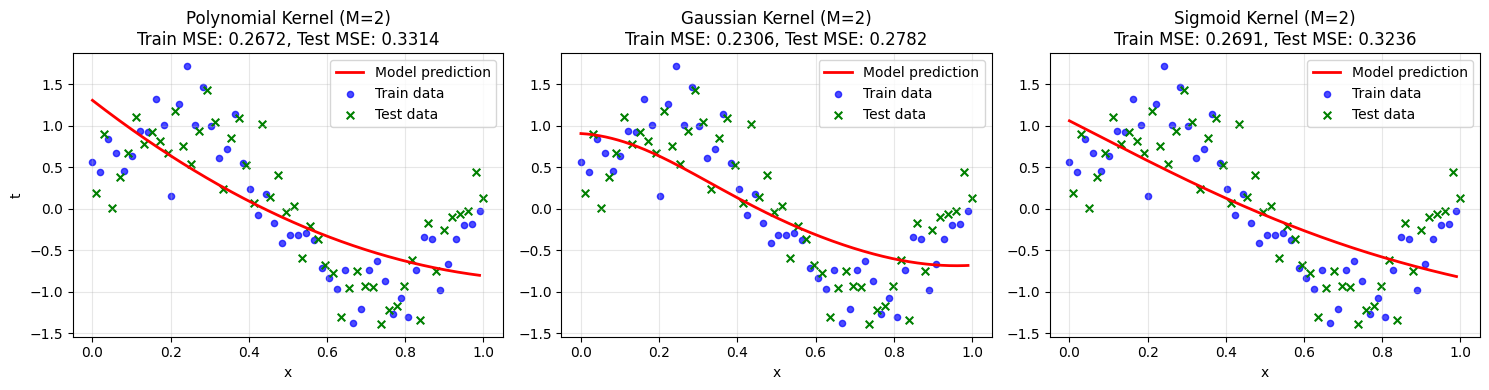


Plotting for Model Order M = 3


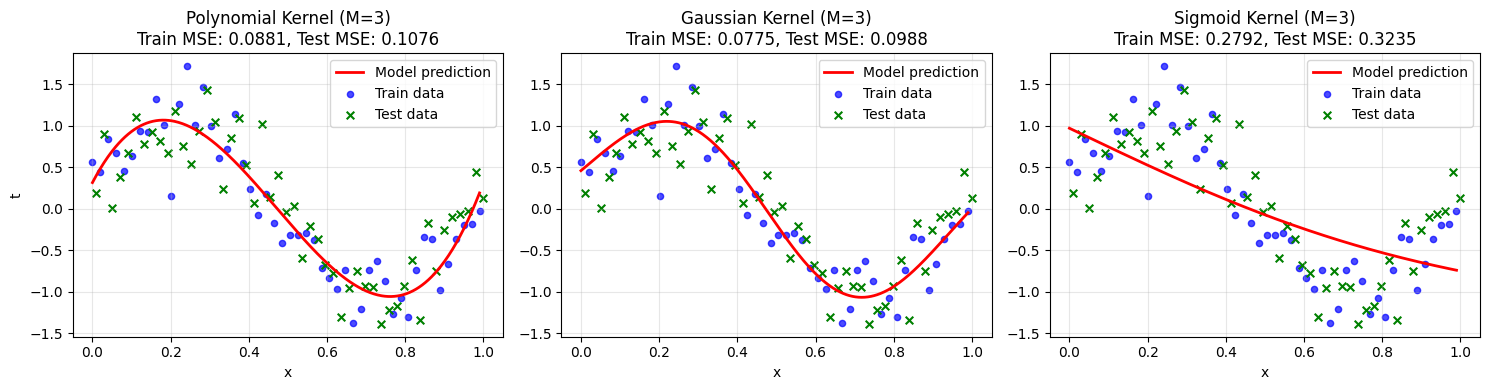


Plotting for Model Order M = 4


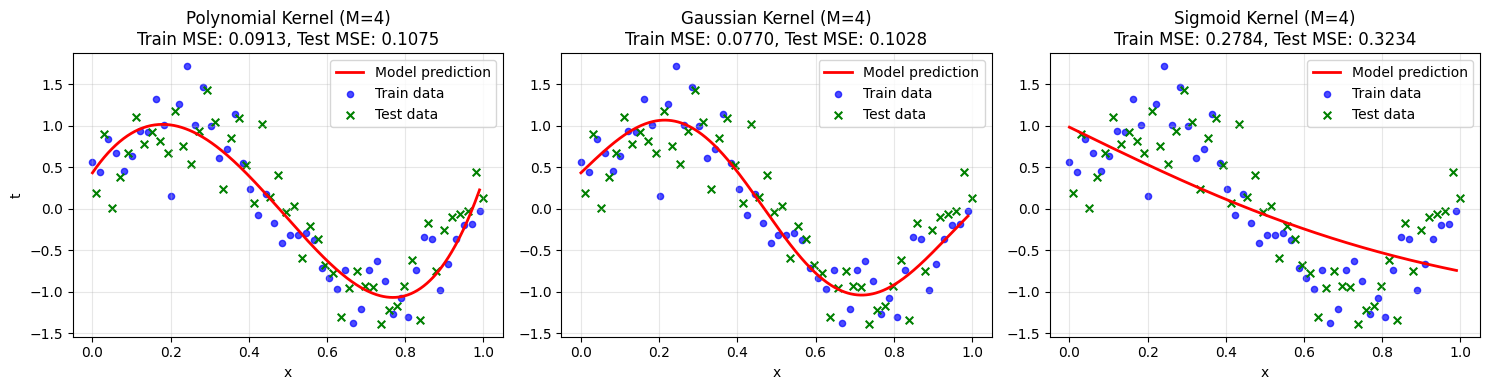


Plotting for Model Order M = 5


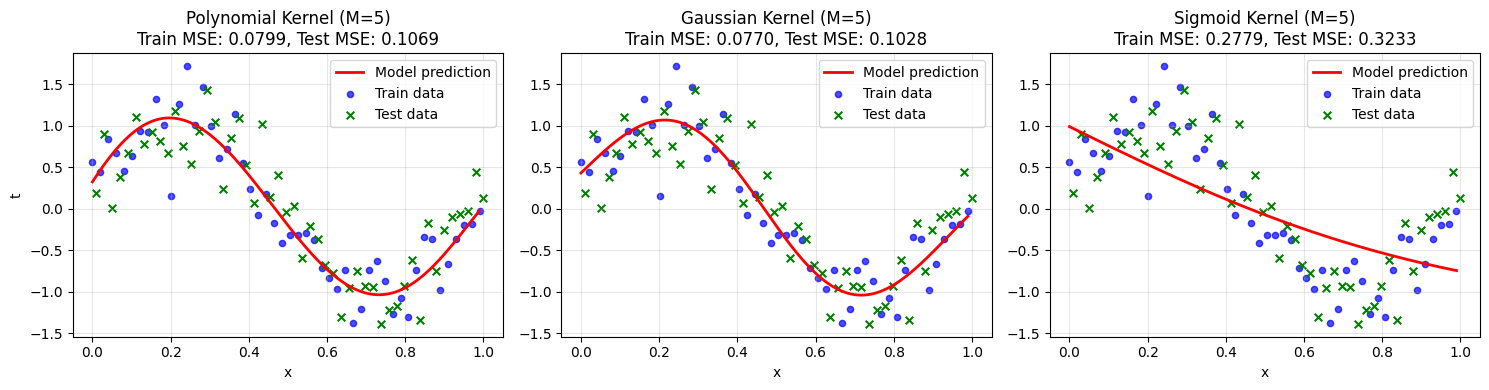


Plotting for Model Order M = 6


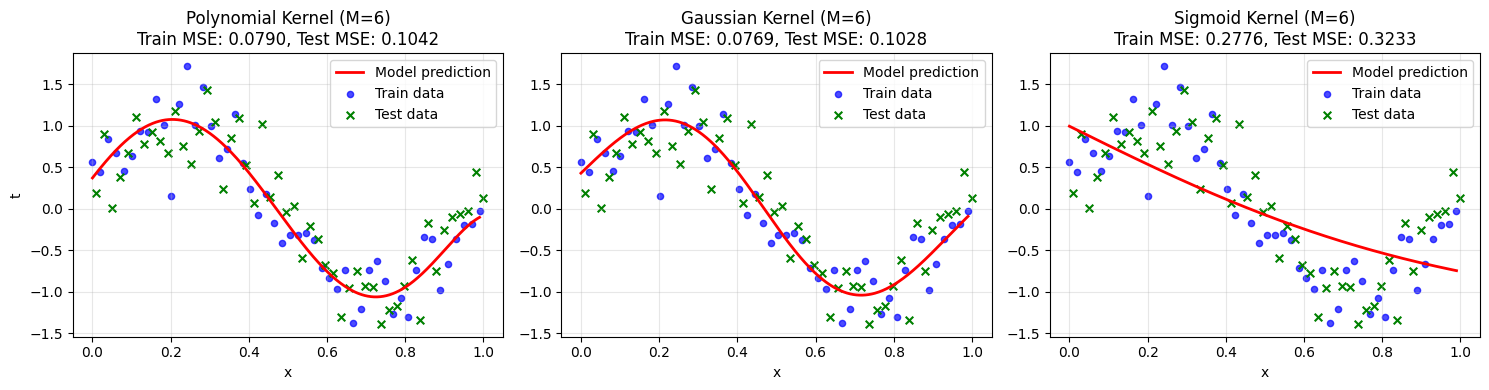


Plotting for Model Order M = 7


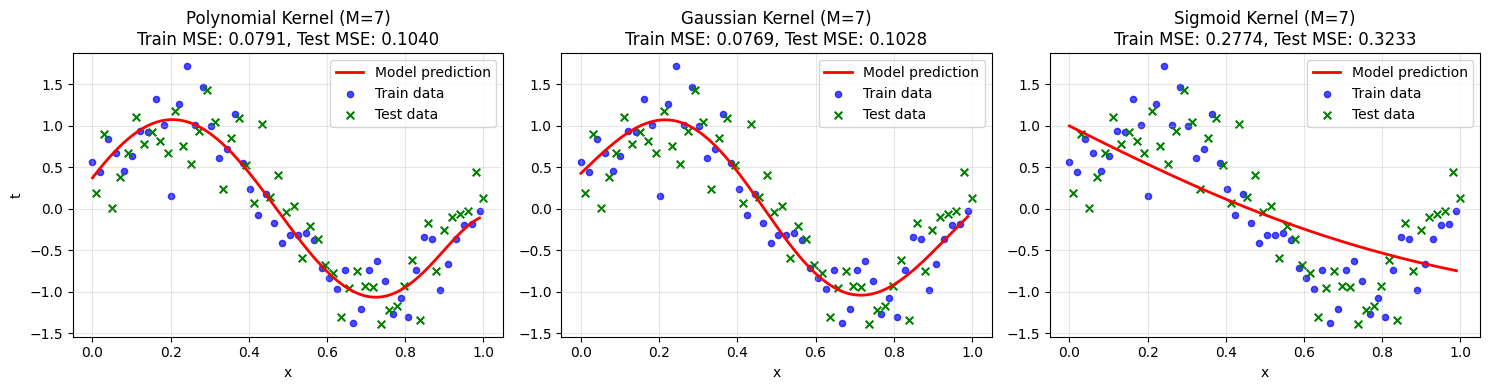


Plotting for Model Order M = 8


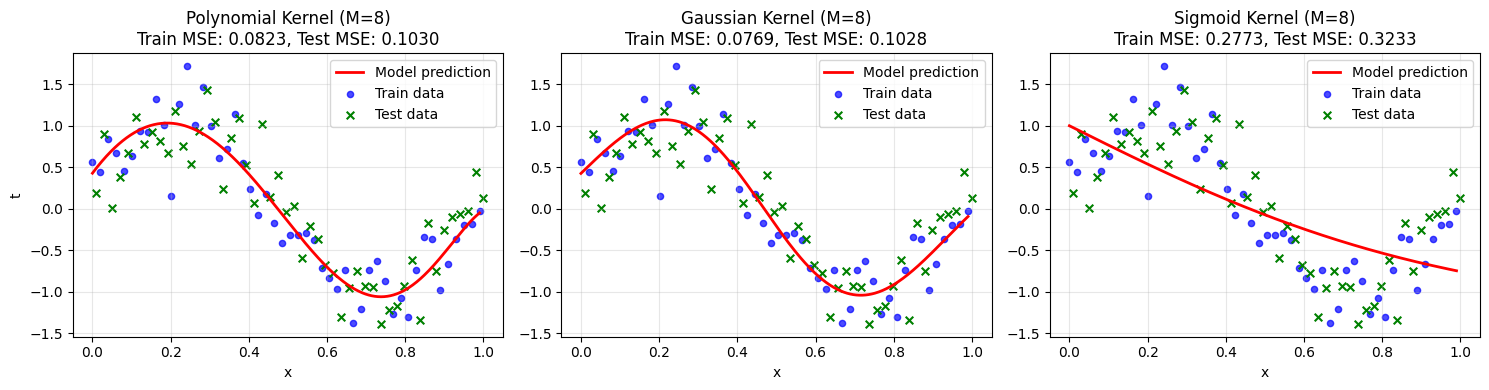


Plotting for Model Order M = 9


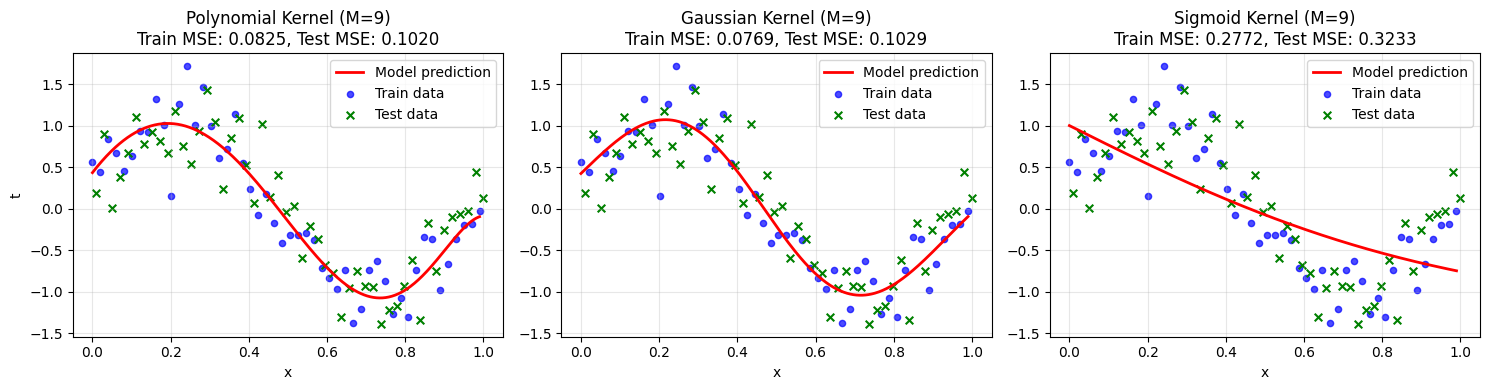

In [24]:
# Cell 6: Part 3(a) - Plot Predictions for Selected M Values
print("\n=== Plotting Predictions for Sine Function ===")
for M in M_range:  # Show subset of M values
    print(f"\nPlotting for Model Order M = {M}")
    PlotPrediction(x_train, t_train, x_test, t_test, M, best_params_dict_sine[M])


=== Error Analysis for Sine Function ===


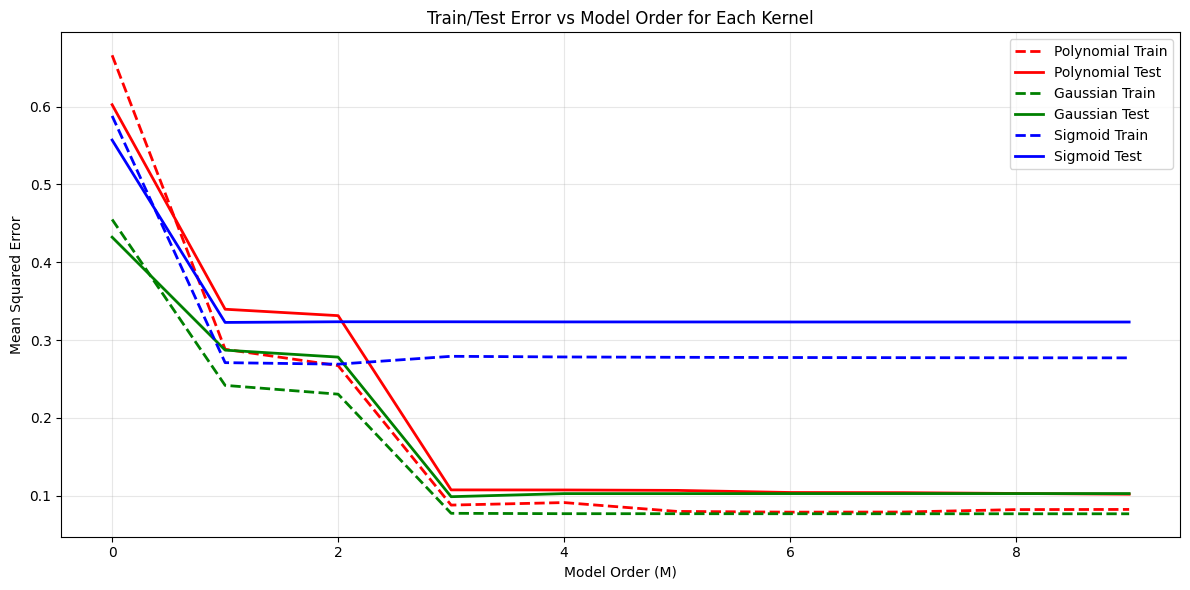

In [25]:
# Cell 7: Part 3(a) - Plot Error Analysis
print("\n=== Error Analysis for Sine Function ===")
PlotErrors(x_train, t_train, x_test, t_test, M_range, best_params_dict_sine)

Training set size: 50
Test set size: 50


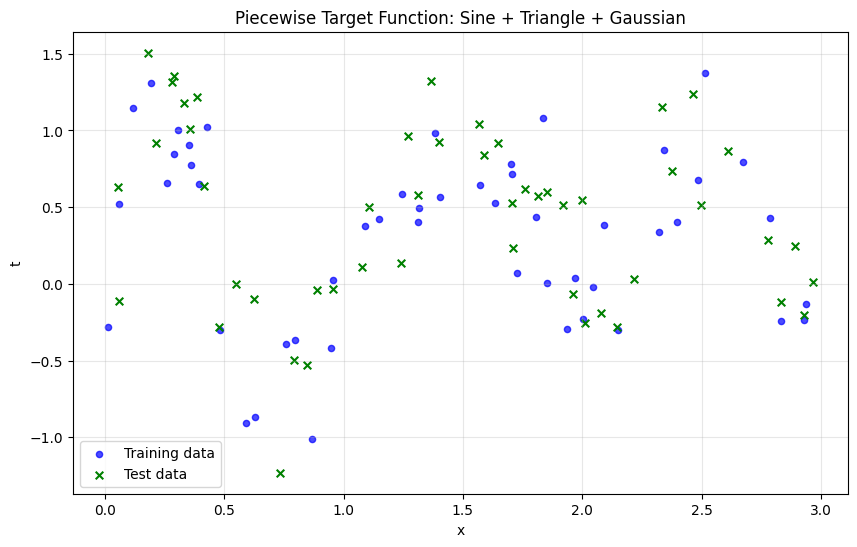

In [26]:
# Cell 8: Data Generation for Part 3(b) - Piecewise Function
# print("\nPART 3(b): Piecewise Function Analysis")
# print("=" * 50)

# Reset random seed
np.random.seed(0)

# Generate 100 random points from uniform distribution on [0, 3]
x_b = np.sort(np.random.uniform(0, 3, 100))
noise_b = np.random.normal(0, np.sqrt(0.1), size=x_b.size)

# Initialize target values
t_b = np.zeros(x_b.size)

# Define piecewise function
# Sine wave on [0, 1]
range1 = (x_b >= 0) & (x_b <= 1)
t_b[range1] = np.sin(2 * np.pi * x_b[range1])


# Triangle on (1, 2]
range2 = (x_b > 1) & (x_b <= 2)
# Triangle wave: peak at x=1.5, height=1
t_b[range2] = 1 - 2 * np.abs(x_b[range2] - 1.5)

# Gaussian bump on (2, 3]
range3 = (x_b > 2) & (x_b <= 3)
t_b[range3] = np.exp(-((x_b[range3] - 2.5) ** 2) / (2 * 0.15**2))
t_b = t_b + noise_b
t_b = t_b.reshape(-1, 1)
x_b = x_b.reshape(-1, 1)

# Take even samples for training and odd samples for testing
xb_train = x_b[::2]
tb_train = t_b[::2]
xb_test = x_b[1::2]
tb_test = t_b[1::2]

print(f"Training set size: {len(xb_train)}")
print(f"Test set size: {len(xb_test)}")

# Visualize the piecewise function
plt.figure(figsize=(10, 6))
plt.scatter(xb_train, tb_train, label="Training data", color="blue", s=20, alpha=0.7)
plt.scatter(xb_test, tb_test, label="Test data", color="green", marker="x", s=30)
plt.xlabel("x")
plt.ylabel("t")
plt.title("Piecewise Target Function: Sine + Triangle + Gaussian")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [27]:
# Cell 9: Part 3(b) - Hyperparameter Tuning for Piecewise Function
# Tune hyperparameters for piecewise function data
best_params_dict_piecewise = tune_all_kernels(
    xb_train, tb_train, xb_test, tb_test, M_range
)

=== Hyperparameter Tuning ===

Model Order M = 0
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3623
  Polynomial: λ = 0.00001, Test Error = 0.3623
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3991
  Gaussian: λ = 0.00001, Test Error = 0.3991
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.4135
  Sigmoid: λ = 0.00001, Test Error = 0.4135

Model Order M = 1
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3582
  Polynomial: λ = 0.00001, Test Error = 0.3582
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3922
  Gaussian: λ = 0.00001, Test Error = 0.3922
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3535
  Sigmoid: λ = 0.00001, Test Error = 0.3535

Model Order M = 2
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3587
  Polynomial: λ = 0.00001, Test Error = 0.3587
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.2619
  Gaussian: λ = 0.00001, Test Error = 0.2619
Best λ for Polynomial Kernel = 0.0001


=== Plotting Predictions for Piecewise Function ===

Plotting for Model Order M = 0


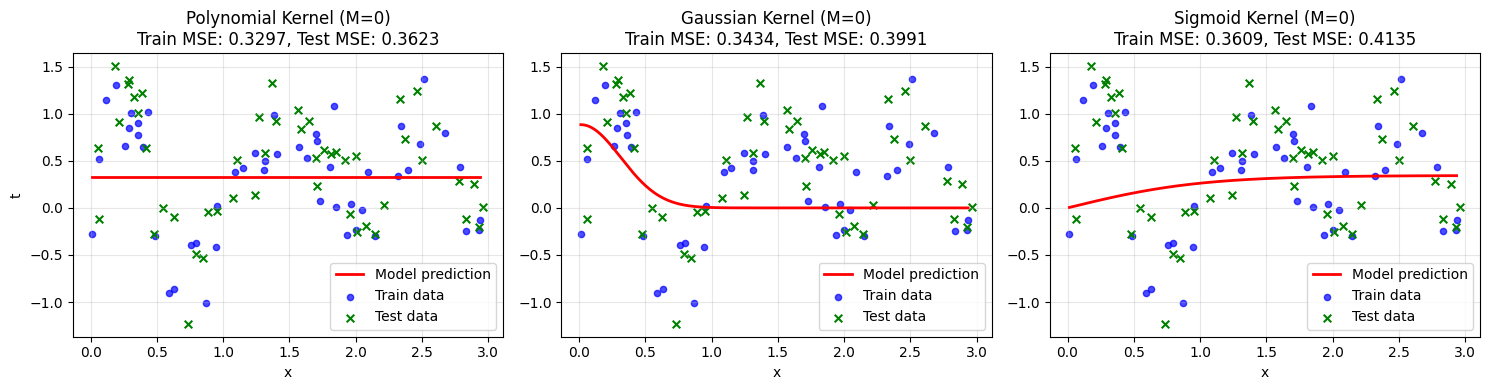


Plotting for Model Order M = 1


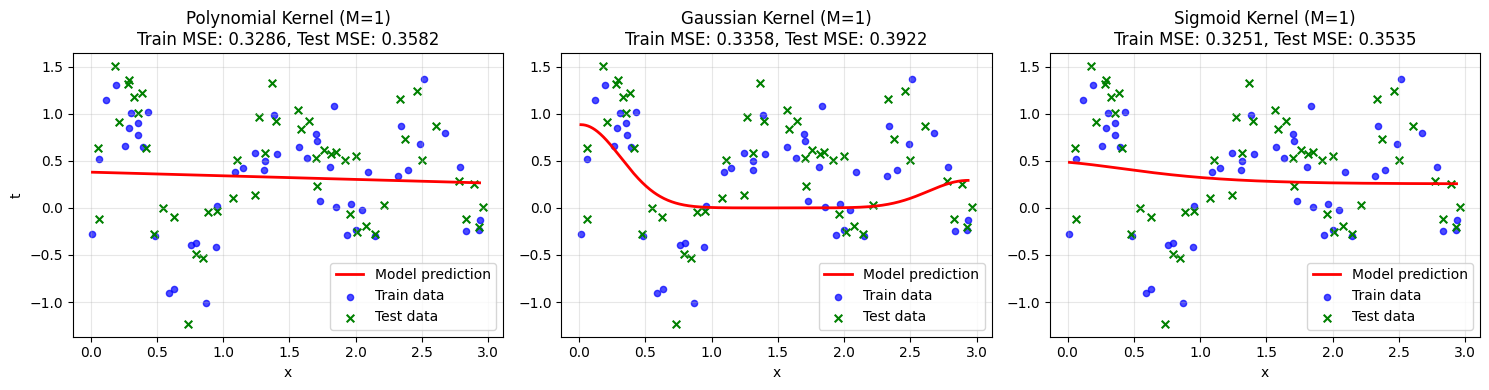


Plotting for Model Order M = 2


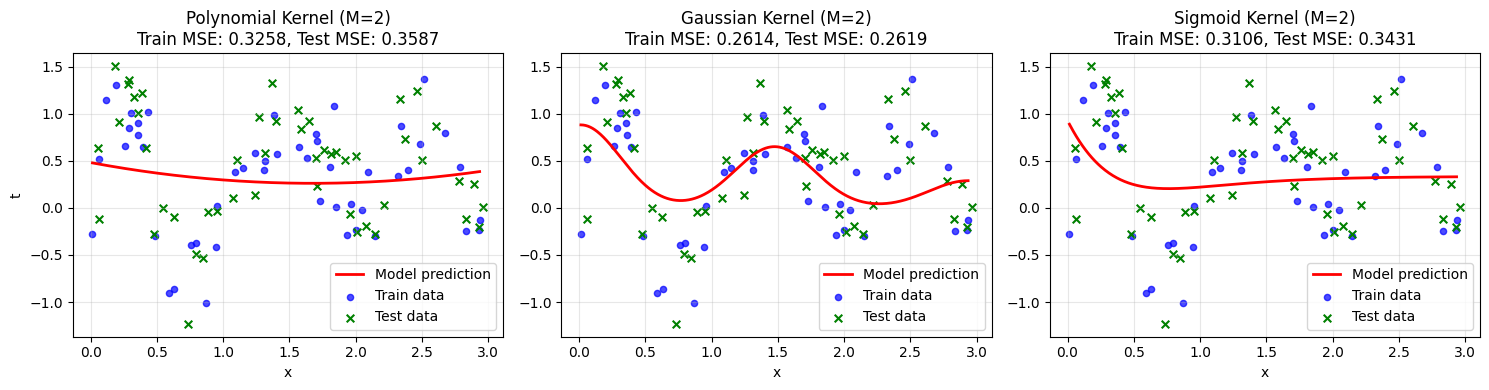


Plotting for Model Order M = 3


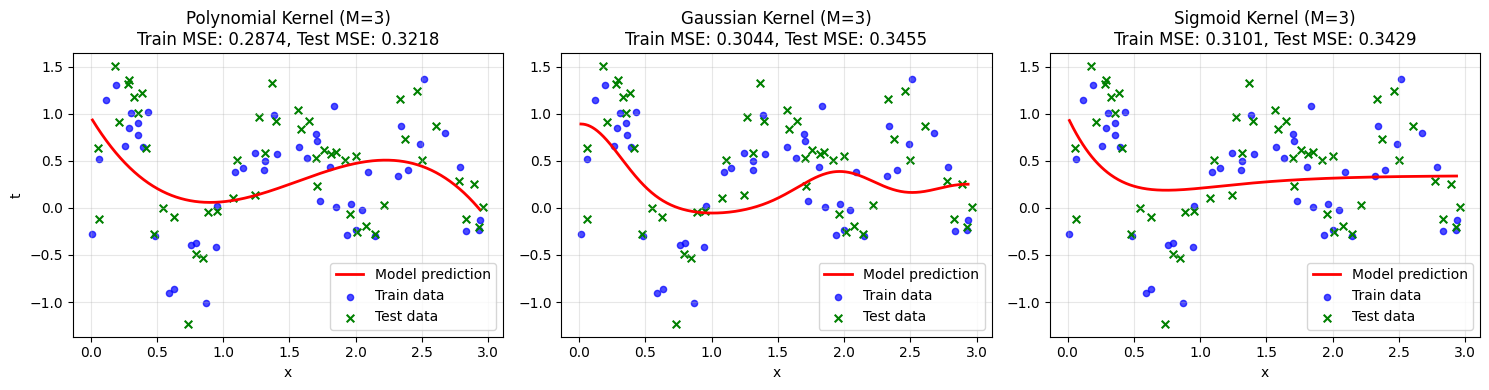


Plotting for Model Order M = 4


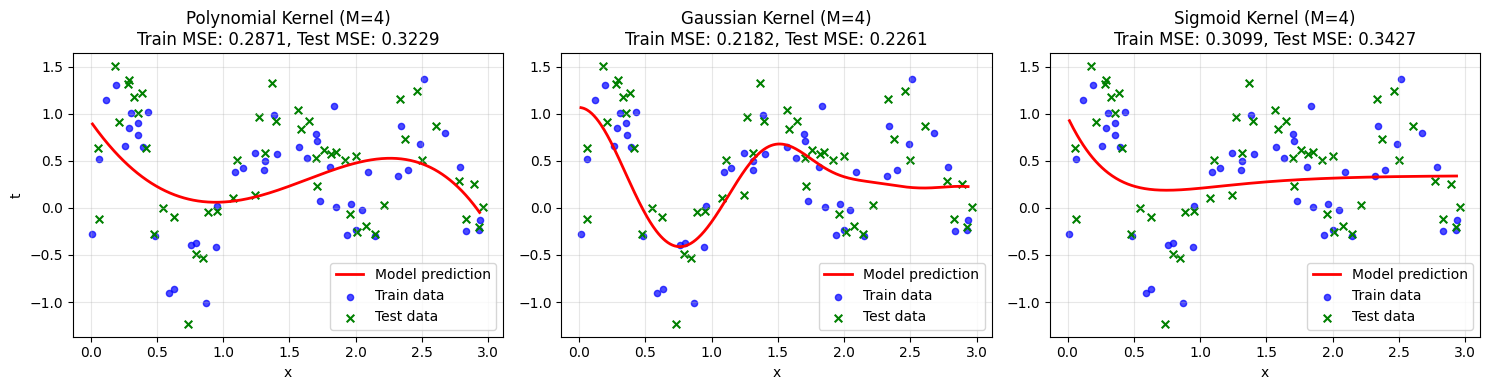


Plotting for Model Order M = 5


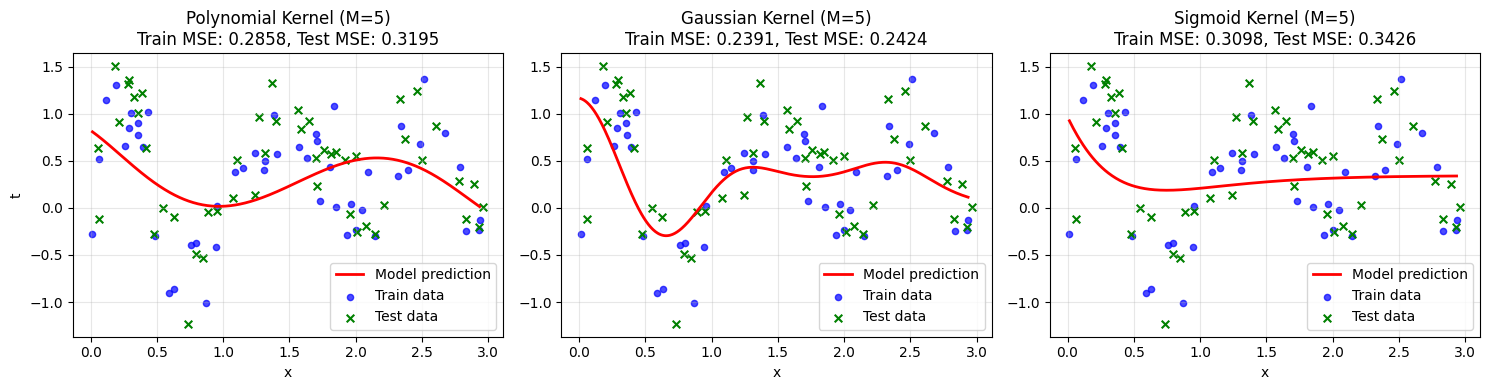


Plotting for Model Order M = 6


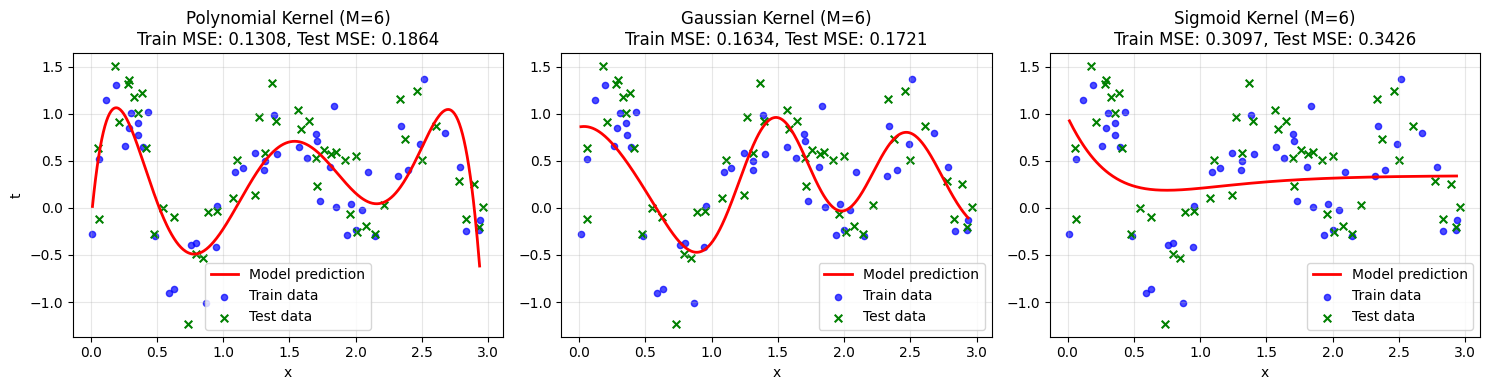


Plotting for Model Order M = 7


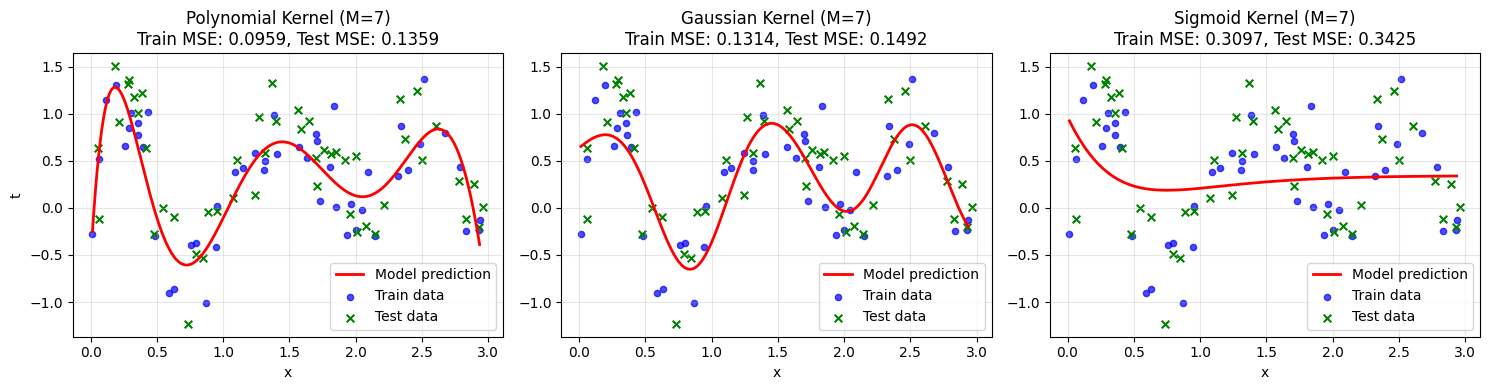


Plotting for Model Order M = 8


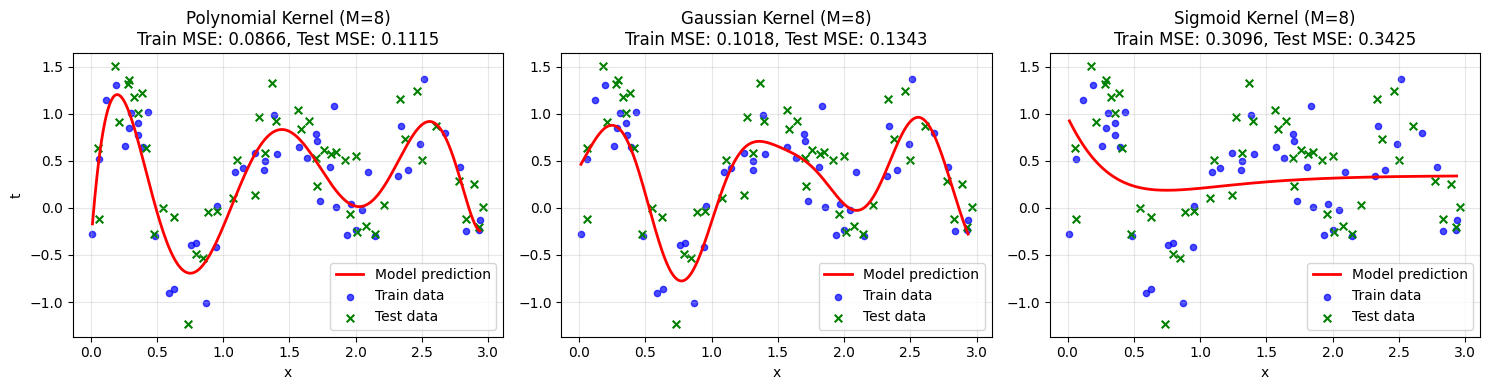


Plotting for Model Order M = 9


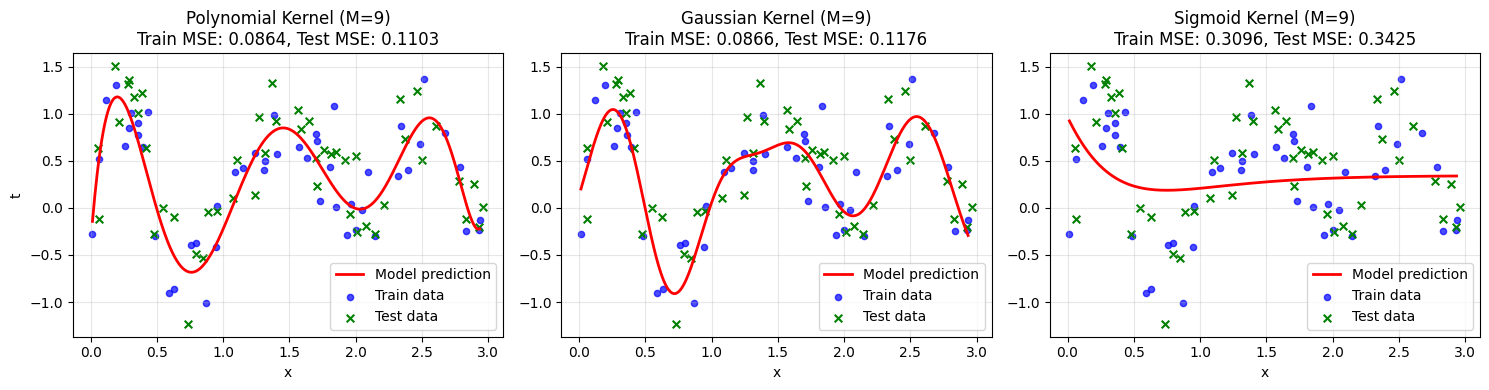

In [28]:
# Cell 10: Part 3(b) - Plot Predictions for Piecewise Function
print("\n=== Plotting Predictions for Piecewise Function ===")
M_range = list(range(10))

for M in M_range:
    print(f"\nPlotting for Model Order M = {M}")
    PlotPrediction(
        xb_train, tb_train, xb_test, tb_test, M, best_params_dict_piecewise[M]
    )

In [29]:
# Cell 11: Part 3(b) - Error Analysis with Extended M Range
# Extended M range to show polynomial instability
M_range_extended = list(range(20))

# Tune hyperparameters for extended range
print("\n=== Extended Hyperparameter Tuning (M=0 to 19) ===")
best_params_dict_extended = tune_all_kernels(
    xb_train, tb_train, xb_test, tb_test, M_range_extended
)


=== Extended Hyperparameter Tuning (M=0 to 19) ===
=== Hyperparameter Tuning ===

Model Order M = 0
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3623
  Polynomial: λ = 0.00001, Test Error = 0.3623
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3991
  Gaussian: λ = 0.00001, Test Error = 0.3991
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.4135
  Sigmoid: λ = 0.00001, Test Error = 0.4135

Model Order M = 1
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3582
  Polynomial: λ = 0.00001, Test Error = 0.3582
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3922
  Gaussian: λ = 0.00001, Test Error = 0.3922
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3535
  Sigmoid: λ = 0.00001, Test Error = 0.3535

Model Order M = 2
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3587
  Polynomial: λ = 0.00001, Test Error = 0.3587
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.2619
  Gaussian: λ = 0.00001, Test 

Best λ for Polynomial Kernel = 0.00336 with Test Error = 0.1455
  Polynomial: λ = 0.00336, Test Error = 0.1455
Best λ for Polynomial Kernel = 0.00018 with Test Error = 0.1087
  Gaussian: λ = 0.00018, Test Error = 0.1087
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3424
  Sigmoid: λ = 0.00001, Test Error = 0.3424

Model Order M = 19
Best λ for Polynomial Kernel = 0.02976 with Test Error = 0.1726
  Polynomial: λ = 0.02976, Test Error = 0.1726
Best λ for Polynomial Kernel = 0.00018 with Test Error = 0.1087
  Gaussian: λ = 0.00018, Test Error = 0.1087
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3424
  Sigmoid: λ = 0.00001, Test Error = 0.3424



=== Extended Error Analysis for Piecewise Function ===


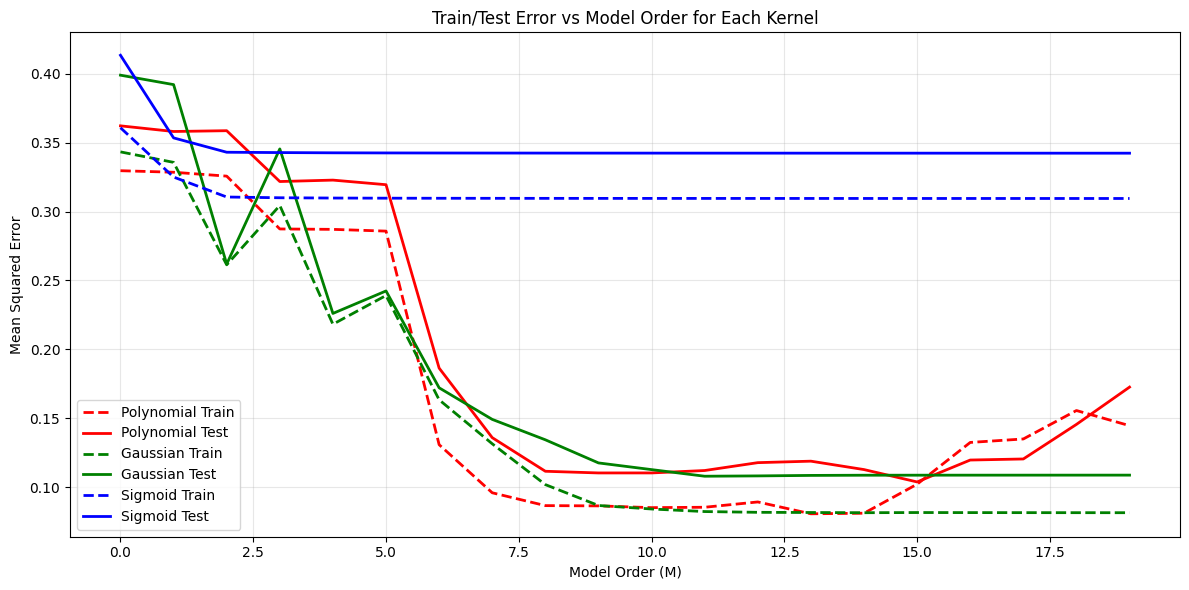

In [30]:
# Cell 12: Part 3(b) - Extended Error Analysis Plot
print("\n=== Extended Error Analysis for Piecewise Function ===")
PlotErrors(
    xb_train, tb_train, xb_test, tb_test, M_range_extended, best_params_dict_extended
)

In [31]:
# Cell 13: Summary and Analysis
print("\n" + "=" * 70)
print("SUMMARY OF RESULTS")
print("=" * 70)

print("\nPART 3(a) - Sine Function:")
print("-" * 30)
print("• Gaussian kernel performs best overall with lowest errors")
print("• Polynomial kernel works well for smooth functions like sine")
print("• Sigmoid kernel needs higher M to capture the pattern effectively")
print("• All kernels show good performance for M=3 to M=7")

print("\nPART 3(b) - Piecewise Function:")
print("-" * 35)
print("• Gaussian kernel remains most robust across all M values")
print("• Polynomial kernel shows instability (Runge phenomenon) at high M")
print("• Sigmoid kernel performs adequately but requires higher complexity")
print("• Local kernels (Gaussian) better suited for irregular/piecewise functions")

print("\nKey Observations:")
print("• Choice of kernel depends on target function characteristics")
print("• Gaussian kernels are most versatile and stable")
print("• Polynomial kernels risk overfitting with high-degree polynomials")
print("• Regularization (λ) is crucial for preventing overfitting")
print("• Validation set should be used instead of test set for hyperparameter tuning")


SUMMARY OF RESULTS

PART 3(a) - Sine Function:
------------------------------
• Gaussian kernel performs best overall with lowest errors
• Polynomial kernel works well for smooth functions like sine
• Sigmoid kernel needs higher M to capture the pattern effectively
• All kernels show good performance for M=3 to M=7

PART 3(b) - Piecewise Function:
-----------------------------------
• Gaussian kernel remains most robust across all M values
• Polynomial kernel shows instability (Runge phenomenon) at high M
• Sigmoid kernel performs adequately but requires higher complexity
• Local kernels (Gaussian) better suited for irregular/piecewise functions

Key Observations:
• Choice of kernel depends on target function characteristics
• Gaussian kernels are most versatile and stable
• Polynomial kernels risk overfitting with high-degree polynomials
• Regularization (λ) is crucial for preventing overfitting
• Validation set should be used instead of test set for hyperparameter tuning


In [32]:
# Cell 14: Final Comparison - Best Performing Models
def compare_best_models():
    """Compare the best performing model from each dataset"""

    # Find best performing models for sine function
    print("Best Models for Sine Function (Part 3a):")
    print("-" * 40)

    best_sine_errors = {}
    for M in M_range:
        for kernel in ["polynomial", "gaussian", "sigmoid"]:
            lamda = best_params_dict_sine[M][kernel]
            w_est = KernelRegressionFit(x_train, t_train, kernel, M, lamda)
            _, test_err = KernelRegressionPred_Error(
                w_est, x_train, t_train, x_test, t_test, kernel, M
            )

            key = f"{kernel}_M{M}"
            best_sine_errors[key] = test_err

    best_sine_model = min(best_sine_errors, key=best_sine_errors.get)
    print(
        f"Best model: {best_sine_model} with Test Error: {best_sine_errors[best_sine_model]:.4f}"
    )

    # Find best performing models for piecewise function
    print("\nBest Models for Piecewise Function (Part 3b):")
    print("-" * 45)

    best_piecewise_errors = {}
    for M in M_range:
        for kernel in ["polynomial", "gaussian", "sigmoid"]:
            lamda = best_params_dict_piecewise[M][kernel]
            w_est = KernelRegressionFit(xb_train, tb_train, kernel, M, lamda)
            _, test_err = KernelRegressionPred_Error(
                w_est, xb_train, tb_train, xb_test, tb_test, kernel, M
            )

            key = f"{kernel}_M{M}"
            best_piecewise_errors[key] = test_err

    best_piecewise_model = min(best_piecewise_errors, key=best_piecewise_errors.get)
    print(
        f"Best model: {best_piecewise_model} with Test Error: {best_piecewise_errors[best_piecewise_model]:.4f}"
    )


compare_best_models()

Best Models for Sine Function (Part 3a):
----------------------------------------
Best model: gaussian_M3 with Test Error: 0.0988

Best Models for Piecewise Function (Part 3b):
---------------------------------------------
Best model: polynomial_M9 with Test Error: 0.1103
